In [1]:
import glob
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib.colors import Colormap
import matplotlib.ticker as ticker

plt.style.use('astro')

In [2]:

# # Base directory where 'pulse_profiles' is located MA'AM's code
# base_dir = '/home/supremekai/thesis/J0243_6p6124/hxmt/rms_deviation_code_same_epoch'

# # Search recursively for all matching fits files
# all_fits_files = glob.glob(os.path.join(base_dir, '**', '*_rms_deviation_flux_errors.fits'), recursive=True)

## When using efold output
base_dir = '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output'

# Search recursively for all matching fits files
all_fits_files = glob.glob(
    #os.path.join(nicer_base_dir, '**', '*_rms_deviation_flux_errors.fits'),
    os.path.join(base_dir,'**','*_pulse_profile_efold_output_same_epoch.fits'),
    recursive=True
)


# Prepare separate lists
le_files = []
me_files = []
he_files = []

# Sort the files into LE, ME, HE
for file in all_fits_files:
    filename = os.path.basename(file)
    if '_LE_' in filename:
        le_files.append(file)
    elif '_ME_' in filename:
        me_files.append(file)
    elif '_HE_' in filename:
        he_files.append(file)

# Sort each list alphabetically (optional)
le_files.sort()
me_files.sort()
he_files.sort()

# Print or use the sorted lists
print(f"Total LE files: {len(le_files)}")
print(f"Total ME files: {len(me_files)}")
print(f"Total HE files: {len(he_files)}")

# Example: print first few from each
print("\nSample LE files:", le_files[:3])
print("Sample ME files:", me_files[:3])
print("Sample HE files:", he_files[:3])


Total LE files: 45
Total ME files: 56
Total HE files: 48

Sample LE files: ['/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/LE/P050419600101_LE_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600102/LE/P050419600102_LE_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600201/LE/P050419600201_LE_pulse_profile_efold_output_same_epoch.fits']
Sample ME files: ['/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/ME/P050419600101_ME_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600102/ME/P050419600102_ME_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600103/ME/P050419600103_ME_pulse_profile_efold_output_same_epoch.fits']
Sample HE files: ['/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_

In [3]:
def extract_exposure_id(filepath):
    """
    Extracts the exposure ID from the file path.
    
    Parameters:
        filepath (str): Full path to the FITS file.
        
    Returns:
        str: Exposure ID.
    """
    # First get the filename without path
    filename = os.path.basename(filepath)
    
    # Use regular expression to find exposure ID pattern (P + digits)
    match = re.match(r'(P\d+)', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Exposure ID not found in {filepath}")

In [4]:
exposure_ids_le = [extract_exposure_id(f) for f in le_files]
exposure_ids_me = [extract_exposure_id(f) for f in me_files]
exposure_ids_he = [extract_exposure_id(f) for f in he_files]

In [5]:
lumin_df=pd.read_csv('hxmt_reporting_spectra.csv',sep="\t")
# Extract the exposure IDs from the DataFrame
lumin_df = lumin_df.rename(columns={'ID ': 'ID'})
lumin_df['ID'] = lumin_df['ID'].astype(str)
lumin_df['ID'] = lumin_df['ID'].str.strip()
exposure_to_lumin = dict(zip(lumin_df['ID'], lumin_df['Lumin']))

In [6]:
lumin_df['ID']

0     P050427900101
1     P050427900103
2     P050427900104
3     P050419600101
4     P050419600102
5     P050419600201
6     P050419600202
7     P050419600301
8     P050419600302
9     P050419600303
10    P050419600401
11    P050419600402
12    P050419600501
13    P050419600502
14    P050419600601
15    P050419600701
16    P050419600702
17    P050419600703
18    P050419600801
19    P050419600901
20    P050419600902
21    P050419601001
22    P050419601101
23    P050419601301
24    P050419601501
25    P050419601502
26    P050419601602
27    P050419601603
28    P050419601701
29    P050419601801
30    P050419601902
31    P050419601903
32    P050419602001
33    P050419602002
34    P050419602101
35    P050419602201
36    P050419602202
37    P050419602203
38    P050419602206
39    P050419602207
40    P050419602208
41    P050419602209
42    P050419602211
Name: ID, dtype: object

In [7]:
def match_exposures_to_luminosity(exposure_ids, fits_files, exposure_to_lumin):
    matched_fits_files = []
    matched_exposure_ids = []
    matched_luminosities = []
    
    unmatched_fits_files = []
    unmatched_exposure_ids = []
    
    for exp_id, file_path in zip(exposure_ids, fits_files):
        # Strip whitespace from exp_id and check again
        exp_id = exp_id.strip()
        
        if exp_id in exposure_to_lumin:
            matched_fits_files.append(file_path)
            matched_exposure_ids.append(exp_id)
            matched_luminosities.append(exposure_to_lumin[exp_id])
        else:
            unmatched_fits_files.append(file_path)
            unmatched_exposure_ids.append(exp_id)
    
    # Statistics
    total_fits = len(fits_files)
    matched_count = len(matched_fits_files)
    unmatched_count = len(unmatched_fits_files)
    
    print(f"Total FITS files: {total_fits}")
    print(f"Matched FITS files to luminosity: {matched_count}")
    print(f"Unmatched FITS files: {unmatched_count}")
    
    # Print unmatched FITS files with a warning
    if unmatched_count > 0:
        print("Warning: Some FITS files were not matched to luminosity values.")
        print("Unmatched FITS files:")
        for unmatched in unmatched_fits_files:
            print(unmatched)
    
    return matched_fits_files, matched_exposure_ids, matched_luminosities

# Apply for each energy band
le_matched_files, le_matched_ids, le_matched_luminosities = match_exposures_to_luminosity(exposure_ids_le, le_files, exposure_to_lumin)
me_matched_files, me_matched_ids, me_matched_luminosities = match_exposures_to_luminosity(exposure_ids_me, me_files, exposure_to_lumin)
he_matched_files, he_matched_ids, he_matched_luminosities = match_exposures_to_luminosity(exposure_ids_he, he_files, exposure_to_lumin)


Total FITS files: 45
Matched FITS files to luminosity: 40
Unmatched FITS files: 5
Unmatched FITS files:
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600602/LE/P050419600602_LE_pulse_profile_efold_output_same_epoch.fits
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600802/LE/P050419600802_LE_pulse_profile_efold_output_same_epoch.fits
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419602205/LE/P050419602205_LE_pulse_profile_efold_output_same_epoch.fits
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419602210/LE/P050419602210_LE_pulse_profile_efold_output_same_epoch.fits
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050427900102/LE/P050427900102_LE_pulse_profile_efold_output_same_epoch.fits
Total FITS files: 56
Matched FITS files to luminosity: 42
Unmatched FITS files: 14
Unmatched FITS files:
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600103/ME/P050419600103_ME_pulse_profil

In [8]:
# Function to extract data from each fits file
def extract_data_from_fits(fits_file):
    with fits.open(fits_file) as hdul:
        # # Extract the relevant columns
        # phase = hdul[1].data['PHASE']
        # avg_flux = hdul[1].data['AVG_FLUX']

        # Extract the columns when efold output is used derived from evt files
        phase=hdul[1].data['PHASE']
        avg_flux=hdul[1].data['RATE1']

        return phase, avg_flux

# Function to normalize the average flux by max value
def normalize_flux(avg_flux):
    max_flux = np.max(avg_flux)
    return avg_flux / max_flux  # Normalize by dividing by the max flux value


def align_pulse_to_minimum(phase, avg_flux):
    """
    Aligns the pulse profile so that the minimum of the average flux occurs at phase = 0.
    """

    phase = np.asarray(phase)
    avg_flux = np.asarray(avg_flux)
    
    # Find the index of the minimum flux
    min_idx = np.argmin(avg_flux)
    
    # Find the phase corresponding to the minimum
    min_phase = phase[min_idx]
    
    # Shift phase so that minimum is at 0
    shifted_phase = (phase - min_phase + 0.02) % 1.0  # modulo to keep between 0 and 1
    
    # Sort by shifted phase to maintain ascending order
    sort_idx = np.argsort(shifted_phase)
    shifted_phase = shifted_phase[sort_idx]
    shifted_flux = avg_flux[sort_idx]
    
    return shifted_phase, shifted_flux

def truncate_colormap(cmap_name='viridis', minval=0.4, maxval=1.04, n=256) -> Colormap:
    """
    Truncates a given matplotlib colormap to a specified range [minval, maxval].

    Parameters:
        cmap_name (str): Name of the base colormap.
        minval (float): Minimum value (between 0 and 1) of the truncated range.
        maxval (float): Maximum value (between 0 and 1) of the truncated range.
        n (int): Number of color bins in the resulting colormap.

    Returns:
        Colormap: A new continuous colormap.
    """
    base_cmap = get_cmap(cmap_name)
    new_cmap = base_cmap(np.linspace(minval, maxval, n))
    return mcolors.LinearSegmentedColormap.from_list(f'{cmap_name}_trunc', new_cmap)


In [9]:
def plot_pulse_profiles_by_obsid(matched_fits_files, min_lum, max_lum,):
    """
    Plots pulse profiles in 2D (phase vs ObsID), sorted by increasing ObsID.
    """

    min_luminosity = min_lum
    max_luminosity = max_lum

    phases = []
    avg_flux_matrix = []
    obs_ids = []

    for fits_file in matched_fits_files:
        obs_id = extract_exposure_id(fits_file)  # Use your defined function

        # Extract data
        phase, avg_flux = extract_data_from_fits(fits_file)
        phases = phase  # Assumes phase binning is consistent
        normalized_flux = normalize_flux(avg_flux)        
        #Align the pulse so that minimum is at phase = 0
        aligned_phase, aligned_flux = align_pulse_to_minimum(phase, normalized_flux)
        
        phases = aligned_phase  # Assuming all phase bins are consistent across files
        normalized_flux = normalize_flux(aligned_flux)  # Normalize the flux values


        avg_flux_matrix.append(normalized_flux)
        obs_ids.append(obs_id)

    # Convert to arrays
    avg_flux_matrix = np.array(avg_flux_matrix)
    obs_ids = np.array(obs_ids)

    # Sort by ObsID (lexicographically by default)
    sort_idx = np.argsort(obs_ids)
    avg_flux_matrix = avg_flux_matrix[sort_idx]
    obs_ids = obs_ids[sort_idx]

    # Assign a numeric Y-axis based on sorted index
    y_ticks = np.arange(len(obs_ids))

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(
        avg_flux_matrix,
        aspect='auto',
        origin='lower',
        cmap='rainbow',
        extent=[phases[0], phases[-1], y_ticks[0], y_ticks[-1]],
        vmin=0.3,
        vmax=1.0
    )
    plt.yticks(ticks=y_ticks, labels=obs_ids)
    plt.colorbar(label='Normalized Pulsed Amplitude')
    plt.minorticks_on()  # Enables minor ticks
    plt.xlabel('Phase')
    plt.ylabel('ObsID')
    plt.title('Pulse Profiles Sorted by ObsID')
    plt.tight_layout()
    plt.show()


In [16]:
def plot_pulse_profiles_by_luminosity(matched_fits_files, matched_luminosities, output_name):
    """
    Plots pulse profiles in 2D (phase vs luminosity), sorted by increasing luminosity.
    """

    phases = []
    avg_flux_matrix = []
    luminosities = []

    for fits_file, luminosity in zip(matched_fits_files, matched_luminosities):
        # Extract and normalize data
        phase, avg_flux = extract_data_from_fits(fits_file)
        normalized_flux = normalize_flux(avg_flux)

        # Align pulse
        aligned_phase, aligned_flux = align_pulse_to_minimum(phase, normalized_flux)
        normalized_flux = normalize_flux(aligned_flux)  # Normalize after alignment

        # Duplicate for two cycles
        double_phase = np.concatenate([aligned_phase, aligned_phase + 1])
        double_flux = np.concatenate([normalized_flux, normalized_flux])

        phases = double_phase  # Will be the same for all profiles
        avg_flux_matrix.append(double_flux)
        luminosities.append(luminosity)

    # Convert to arrays and sort by luminosity
    avg_flux_matrix = np.array(avg_flux_matrix)
    luminosities = np.array(luminosities)
    sort_idx = np.argsort(luminosities)

    avg_flux_matrix = avg_flux_matrix[sort_idx]
    luminosities = luminosities[sort_idx]

    # Create plot
    plt.figure(figsize=(6, 5))
    y_ticks = np.arange(len(luminosities))

    # Choose every Nth label to display
    N = 5  # You can tweak this value based on number of profiles
    tick_indices = y_ticks[::N]
    tick_labels = [f"{luminosities[i]/1e37:.2f}" for i in tick_indices]  # Convert to units of 1e37

    plt.imshow(
        avg_flux_matrix,
        aspect='auto',
        origin='lower',
        cmap='rainbow',
        extent=[phases[0], phases[-1], y_ticks[0], y_ticks[-1]],
        vmin=0.3,
        vmax=1.0
    )

    plt.yticks(ticks=tick_indices, labels=tick_labels)
    plt.colorbar(label=r'Normalized Pulse Amplitude')
    plt.xlabel('Phase')
    plt.ylabel(r'Luminosity ($L_{37}$)')
    plt.tight_layout()
    plt.minorticks_on()
    plt.savefig(output_name, dpi=500)
    plt.show()

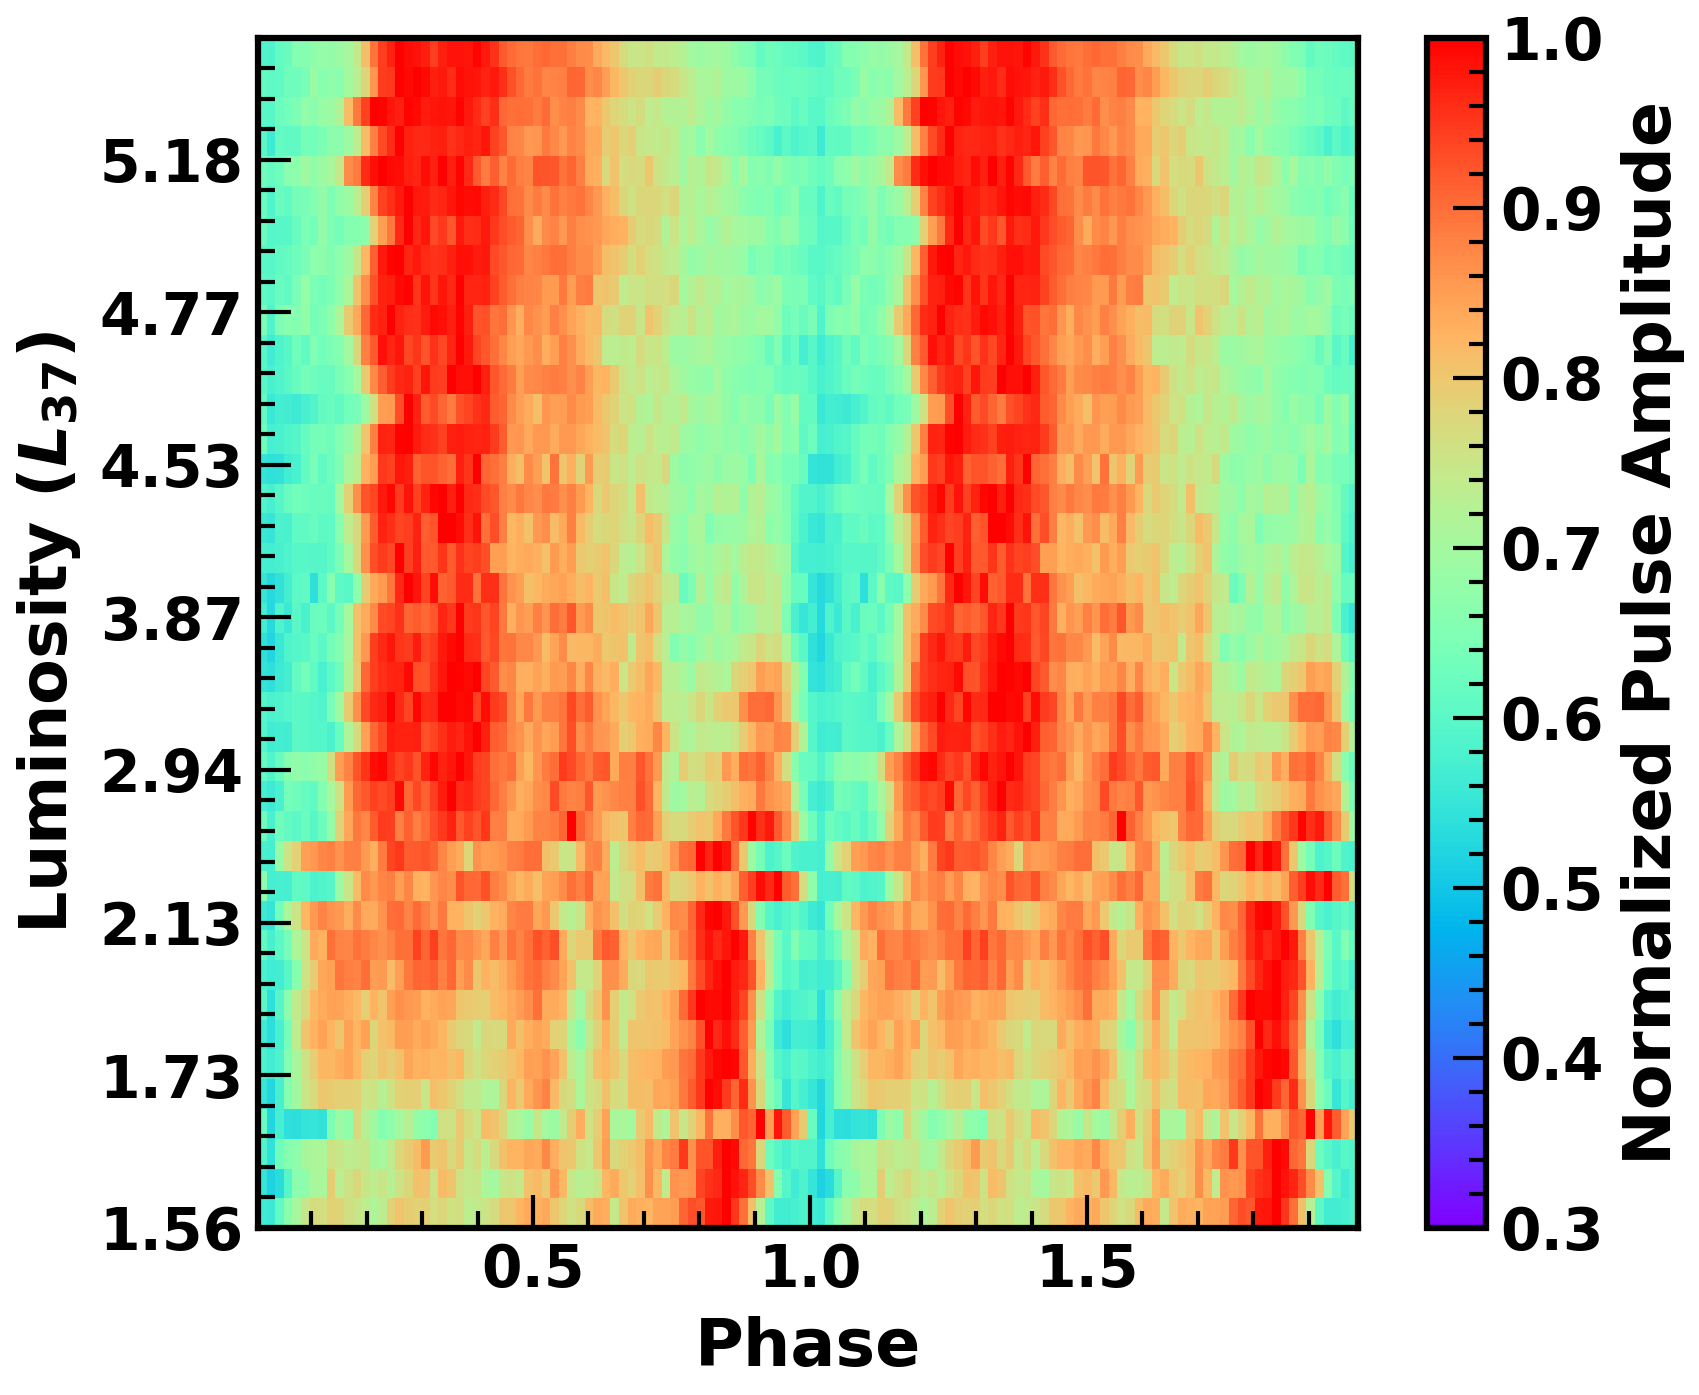

In [17]:
# Call the function for plotting
plot_pulse_profiles_by_luminosity(le_matched_files, le_matched_luminosities,"/home/supremekai/thesis/J0243_6p6124/pulseVluminLE.png")

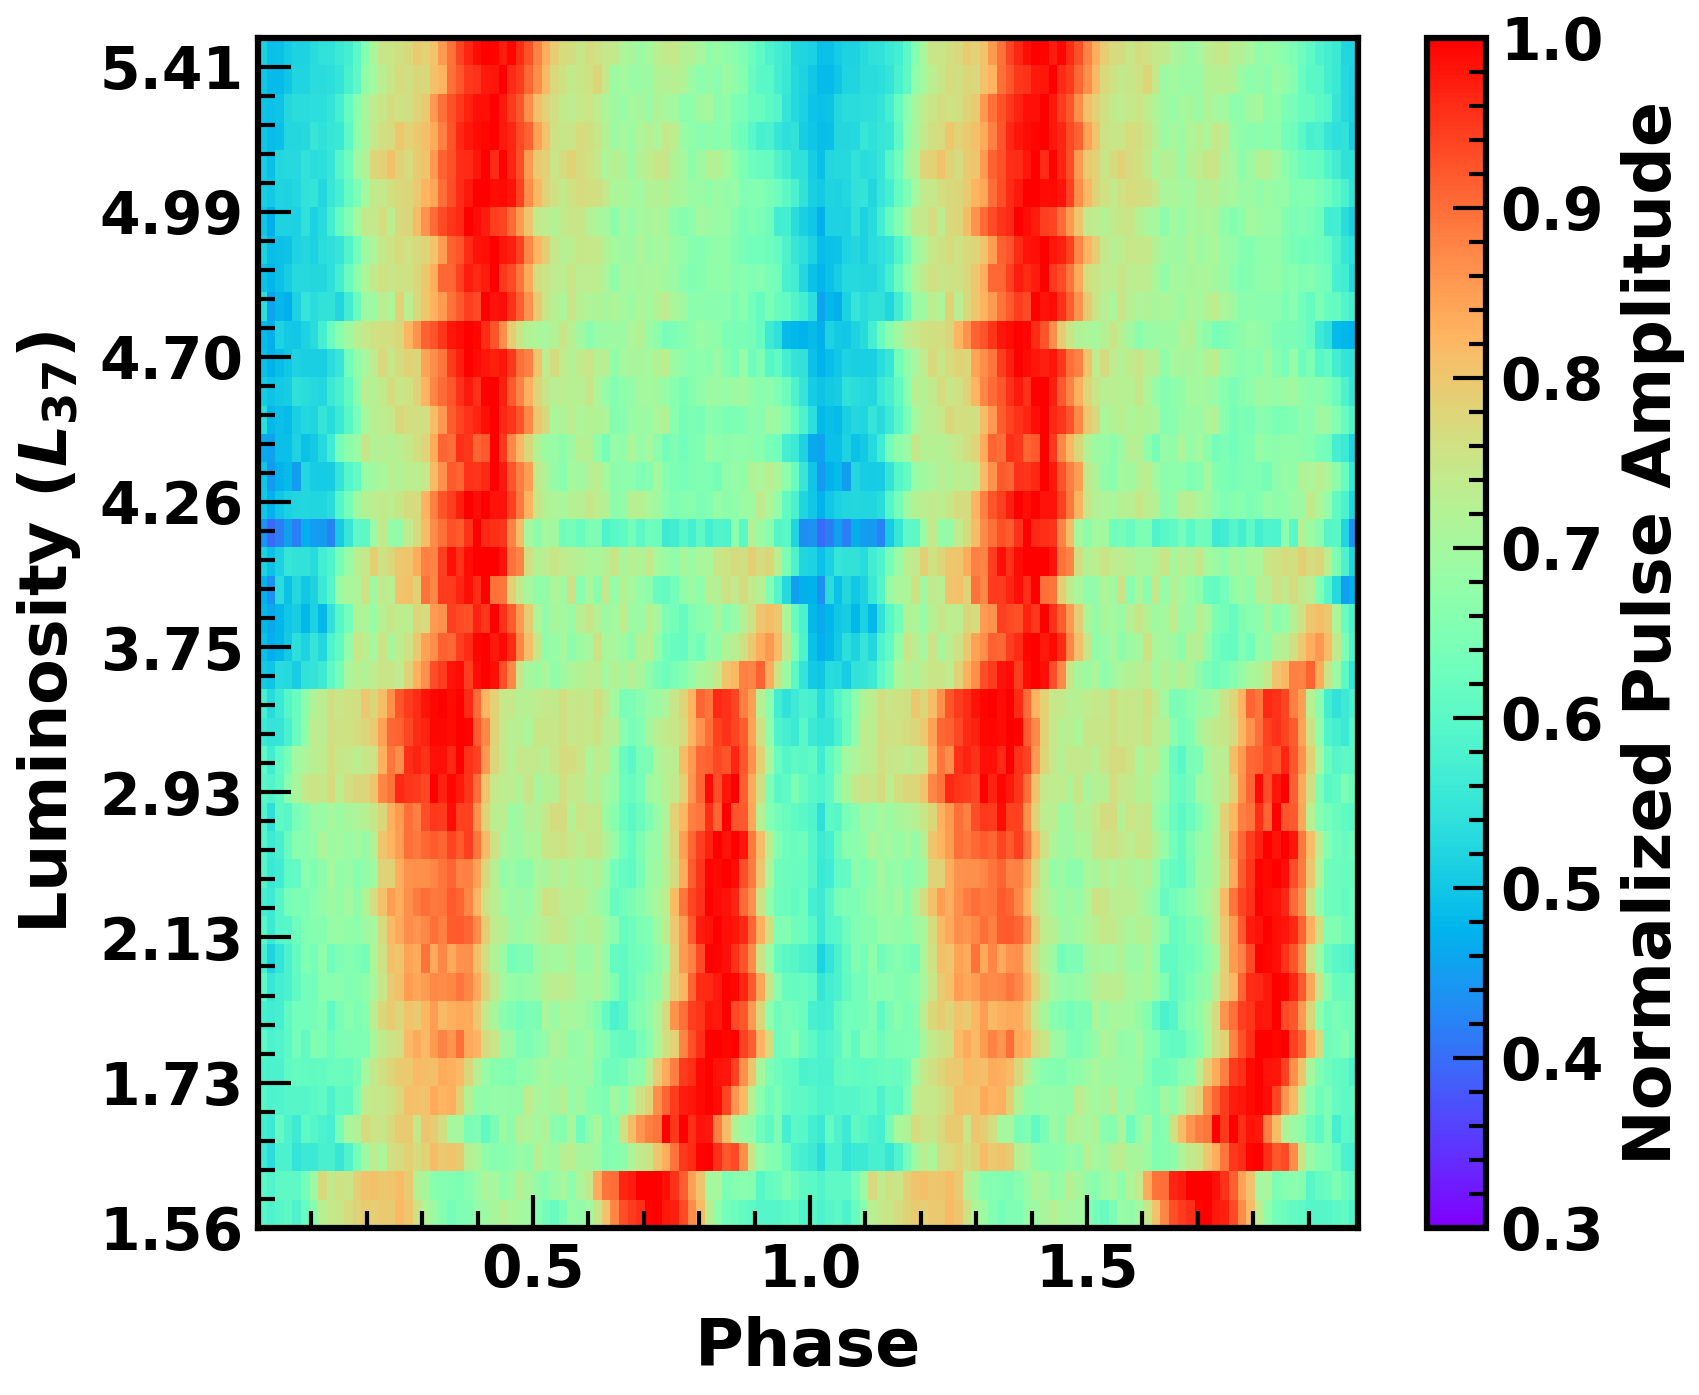

In [18]:
plot_pulse_profiles_by_luminosity(me_matched_files, me_matched_luminosities,"/home/supremekai/thesis/J0243_6p6124/pulseVluminME.png")

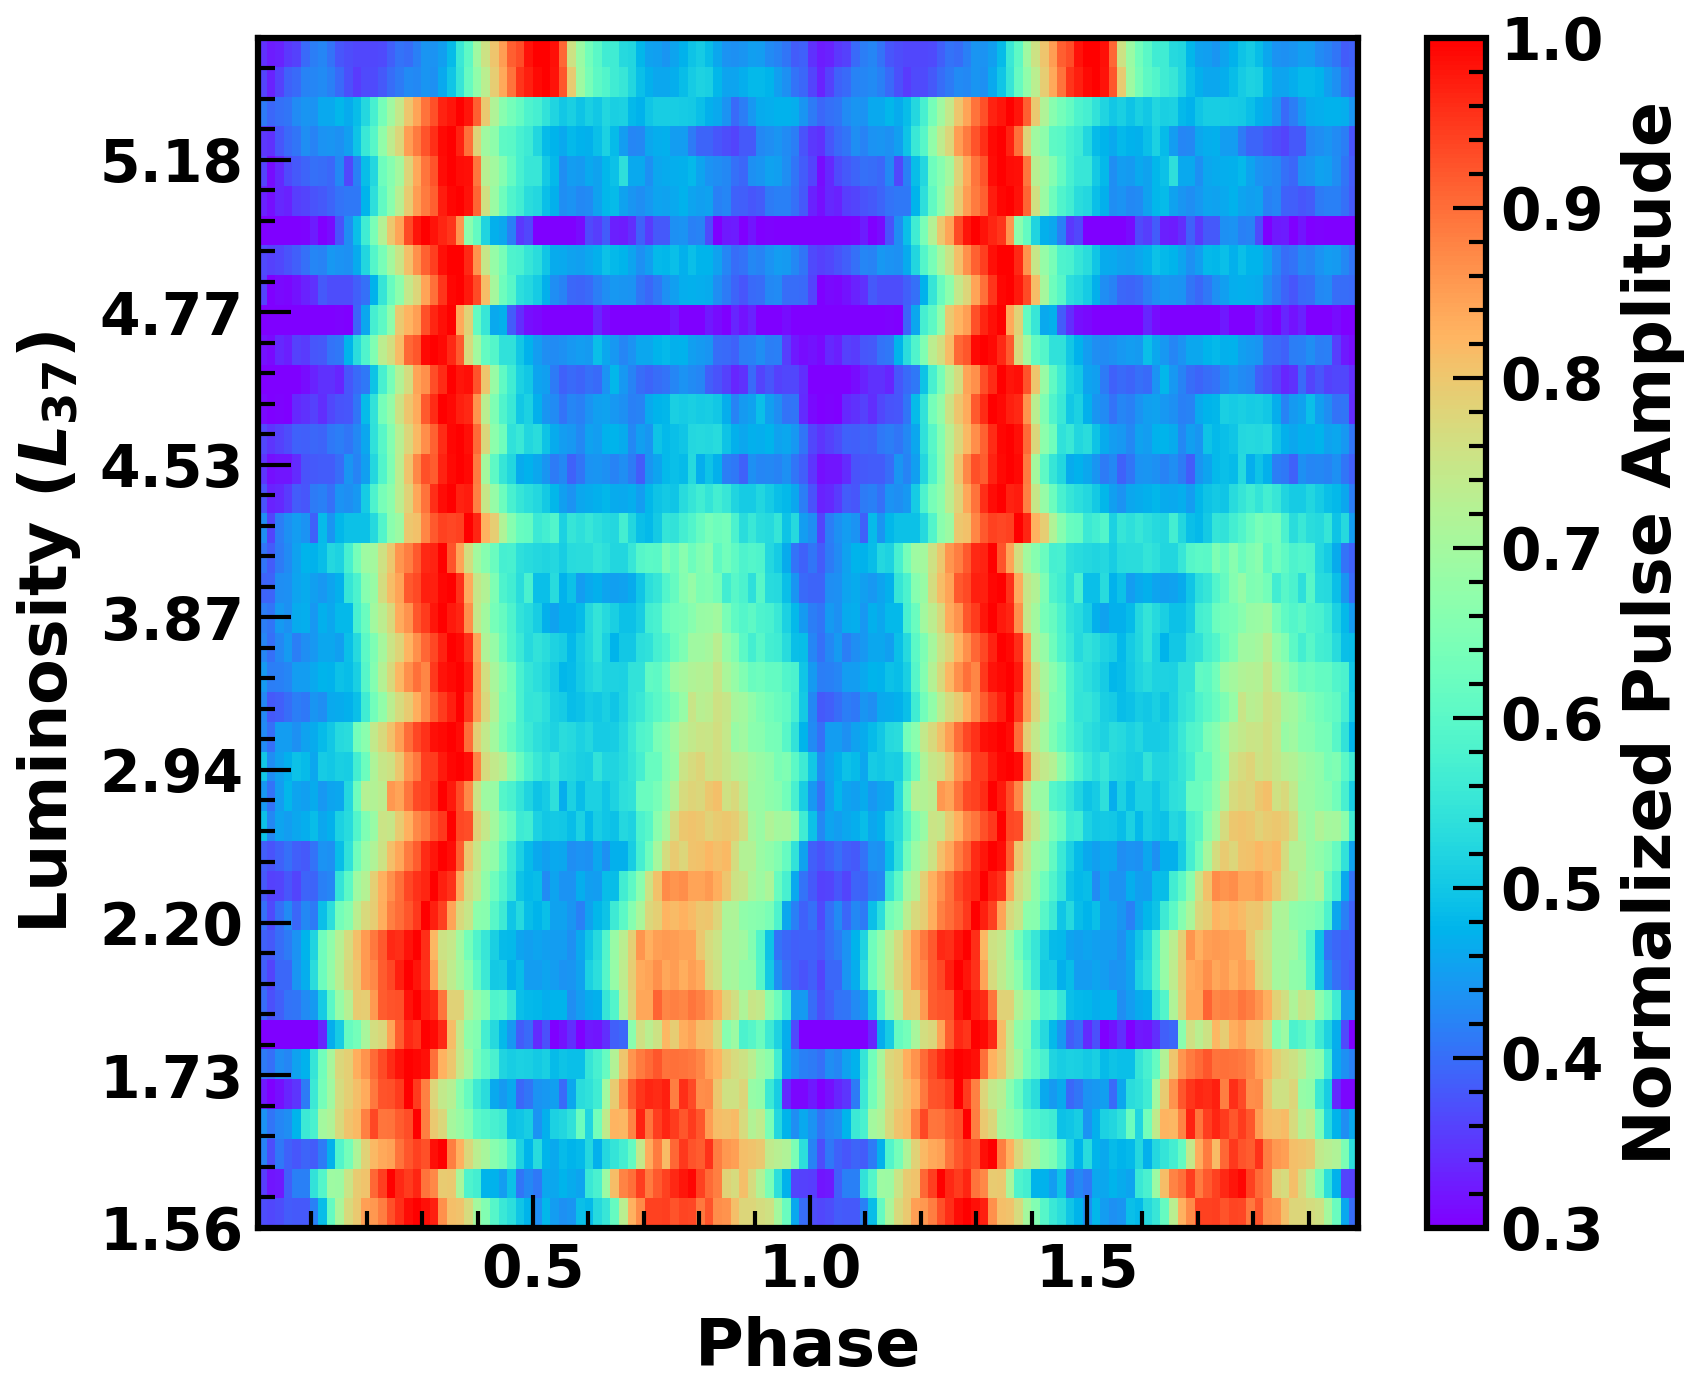

In [19]:
plot_pulse_profiles_by_luminosity(he_matched_files, he_matched_luminosities,"/home/supremekai/thesis/J0243_6p6124/pulseVluminHE.png")

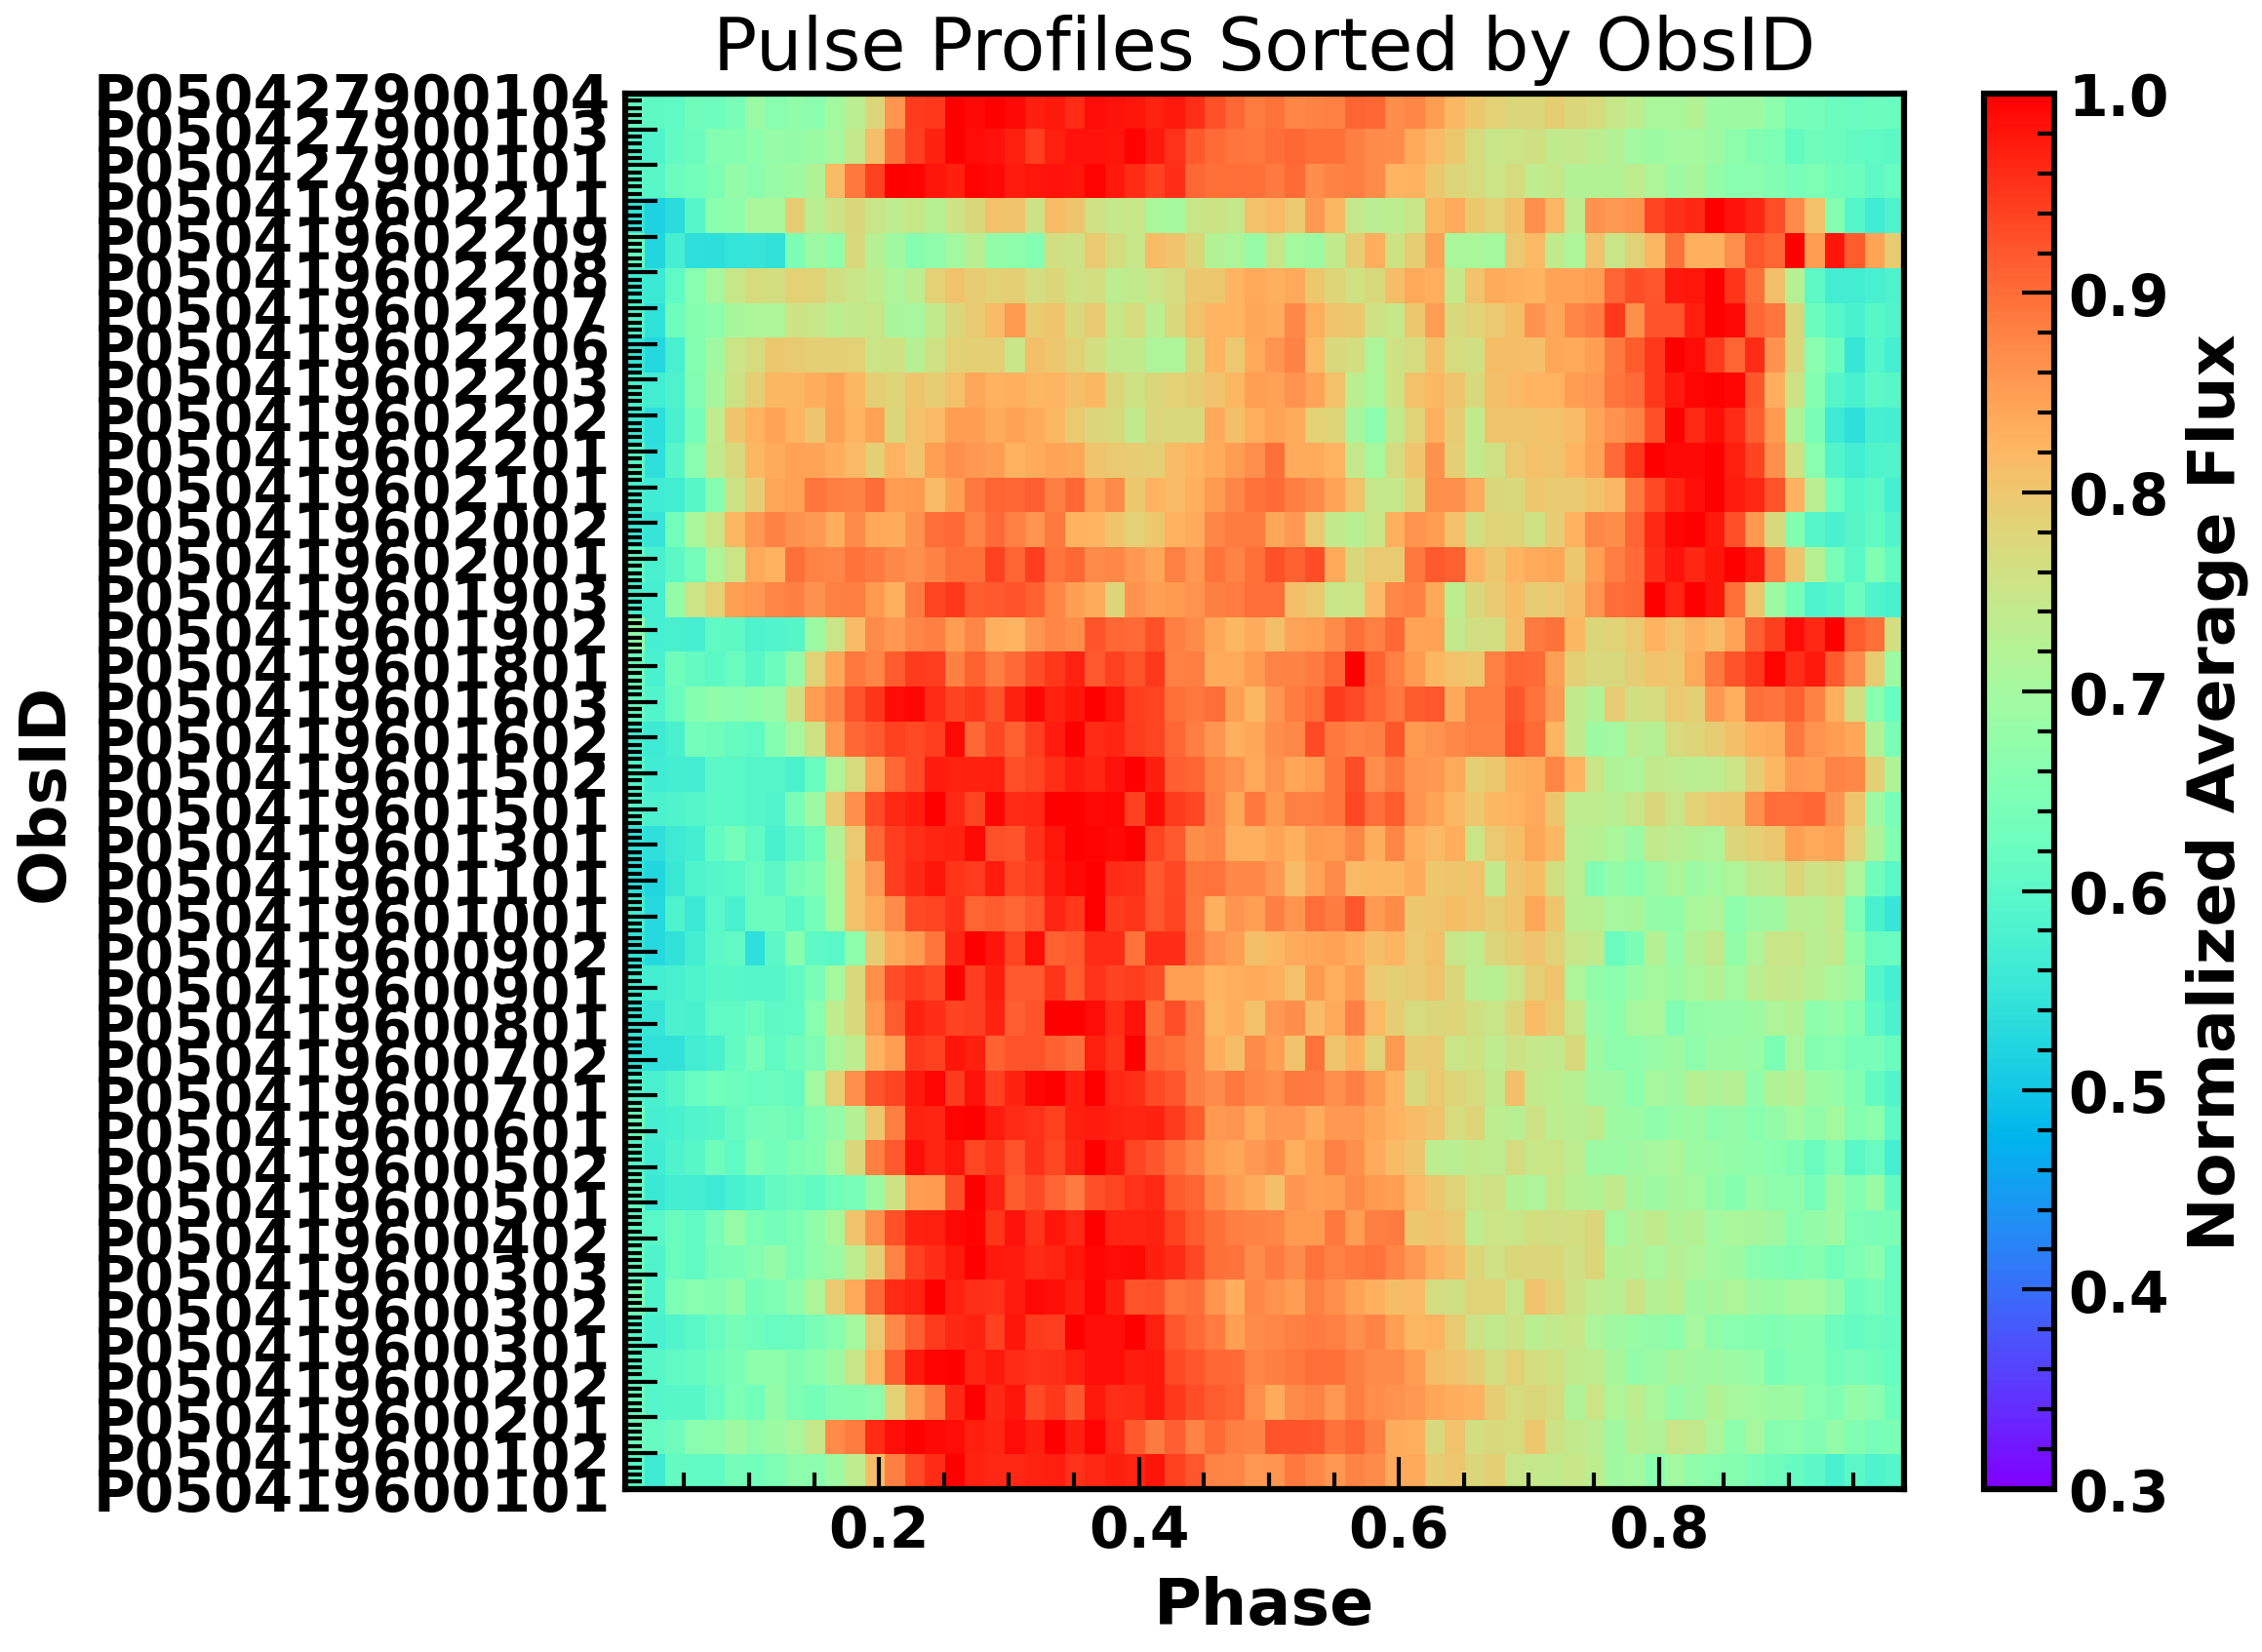

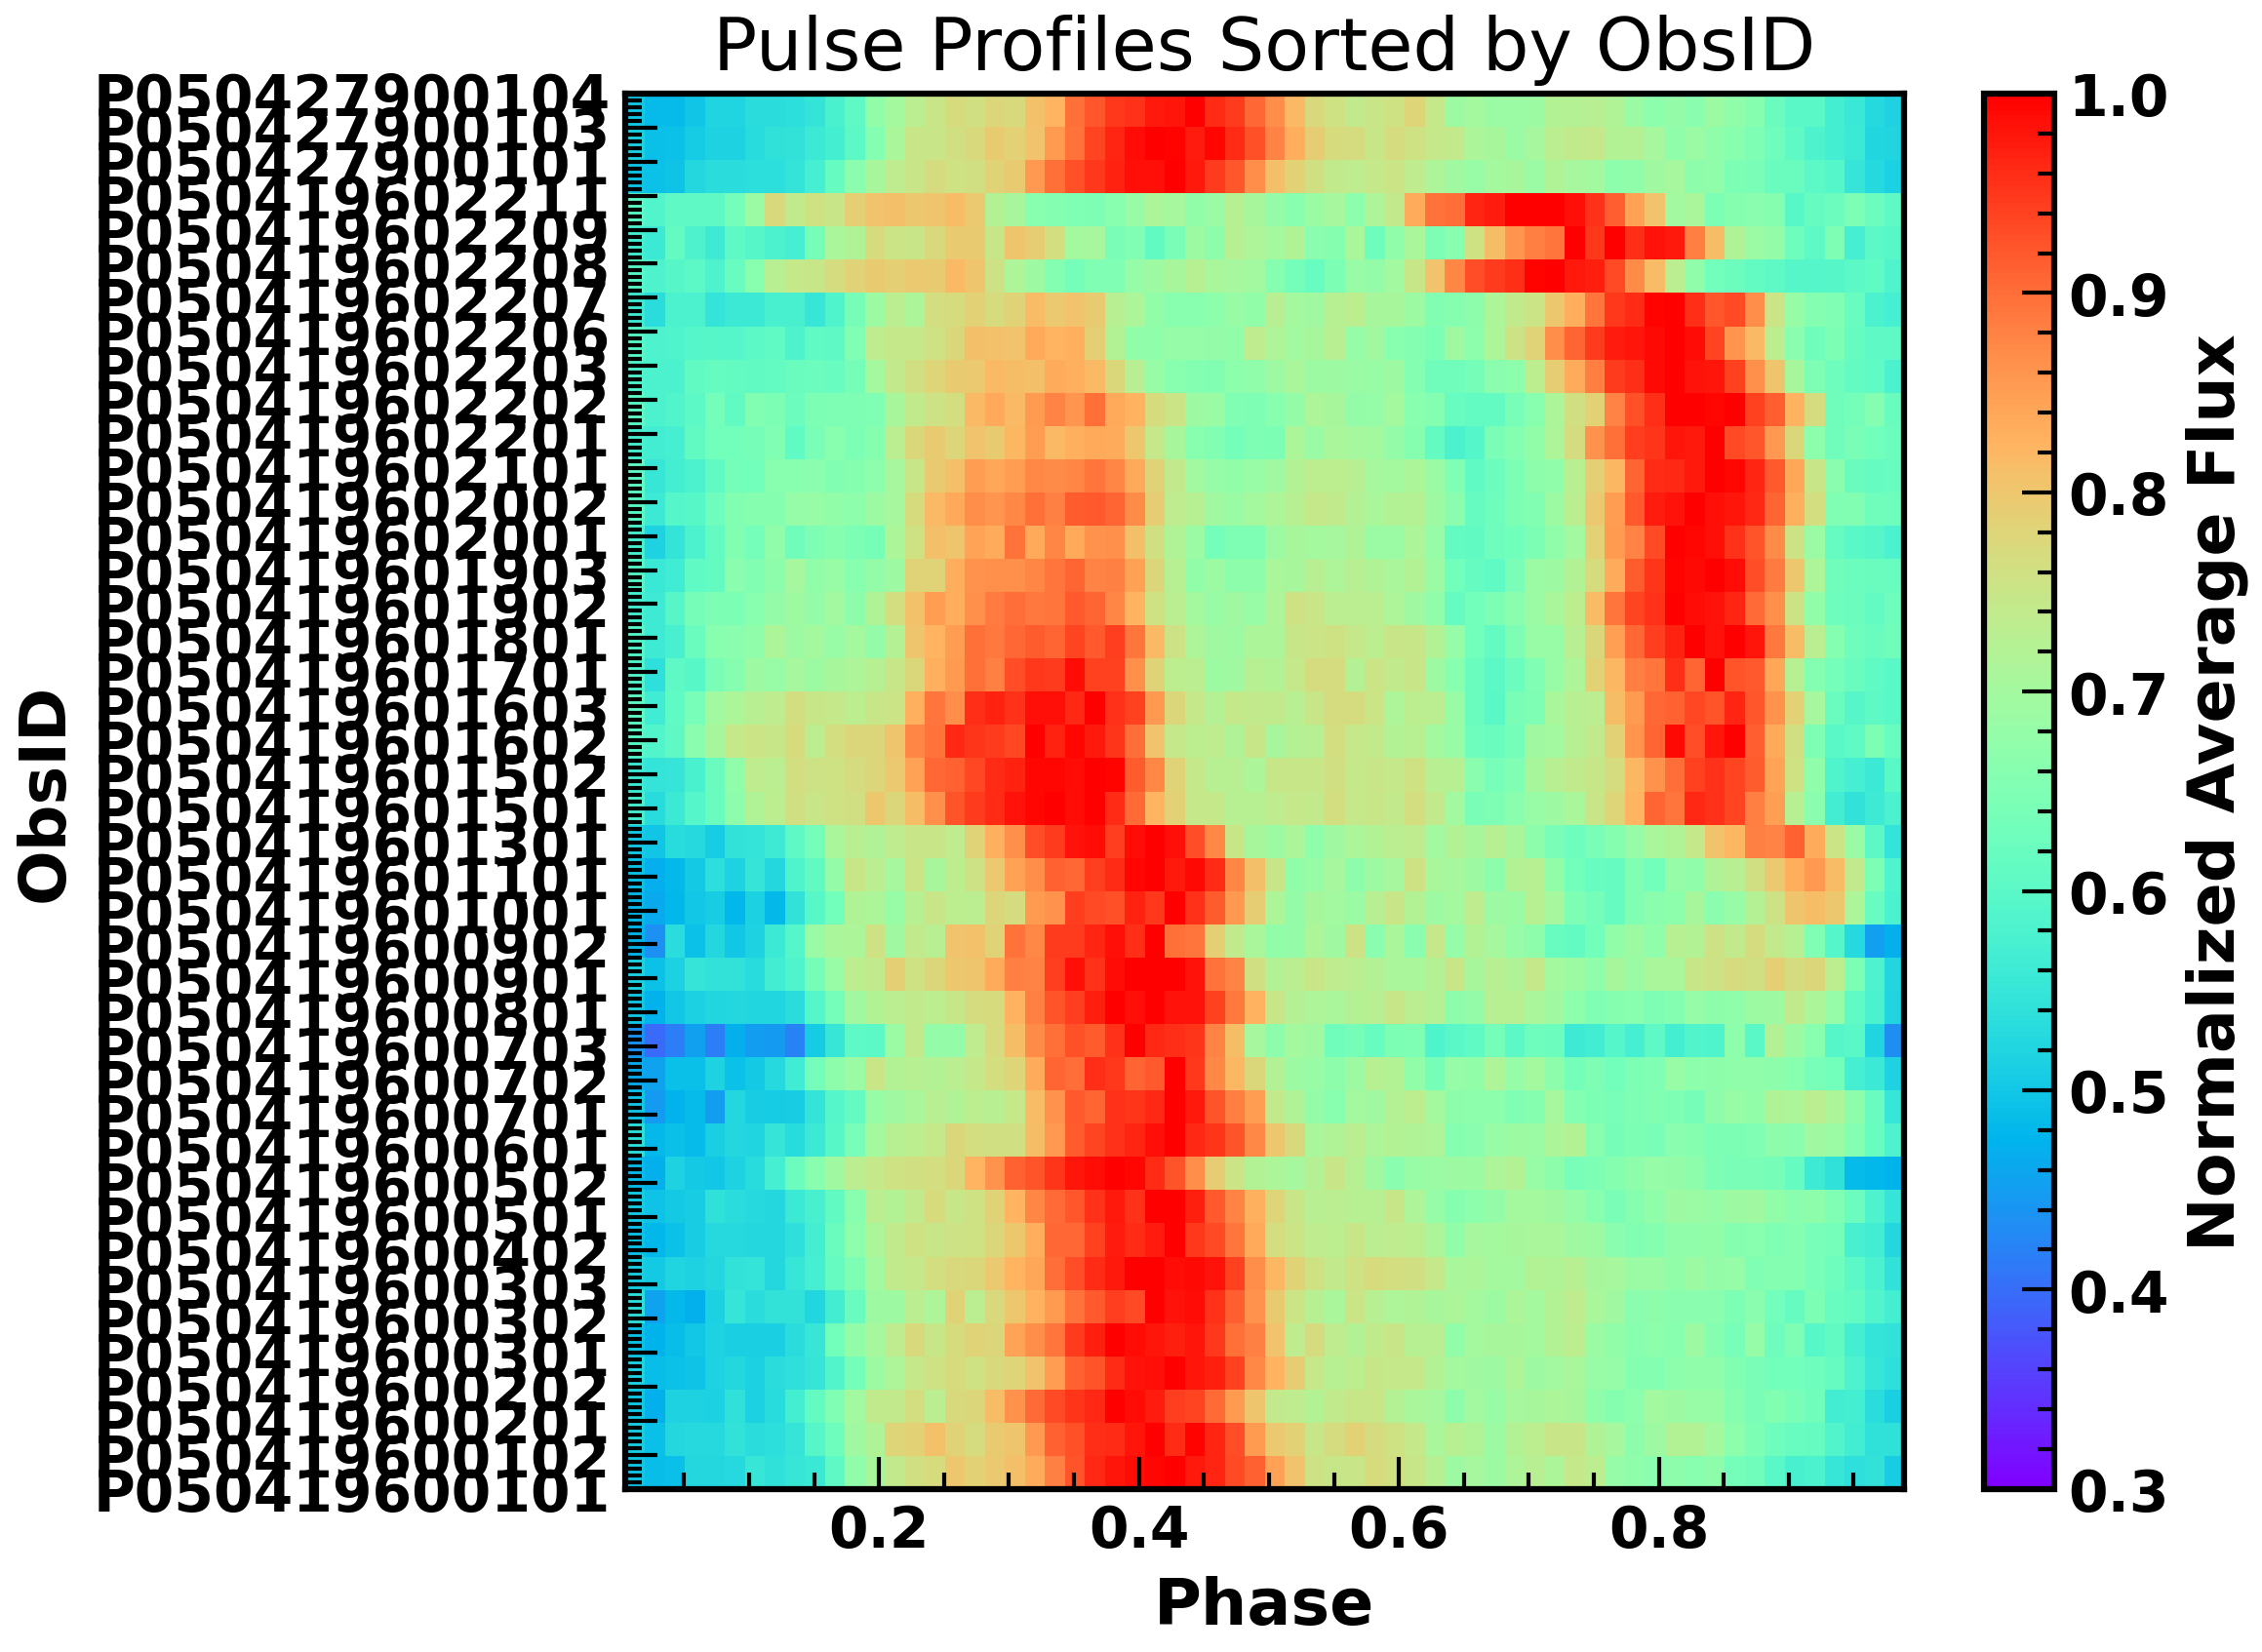

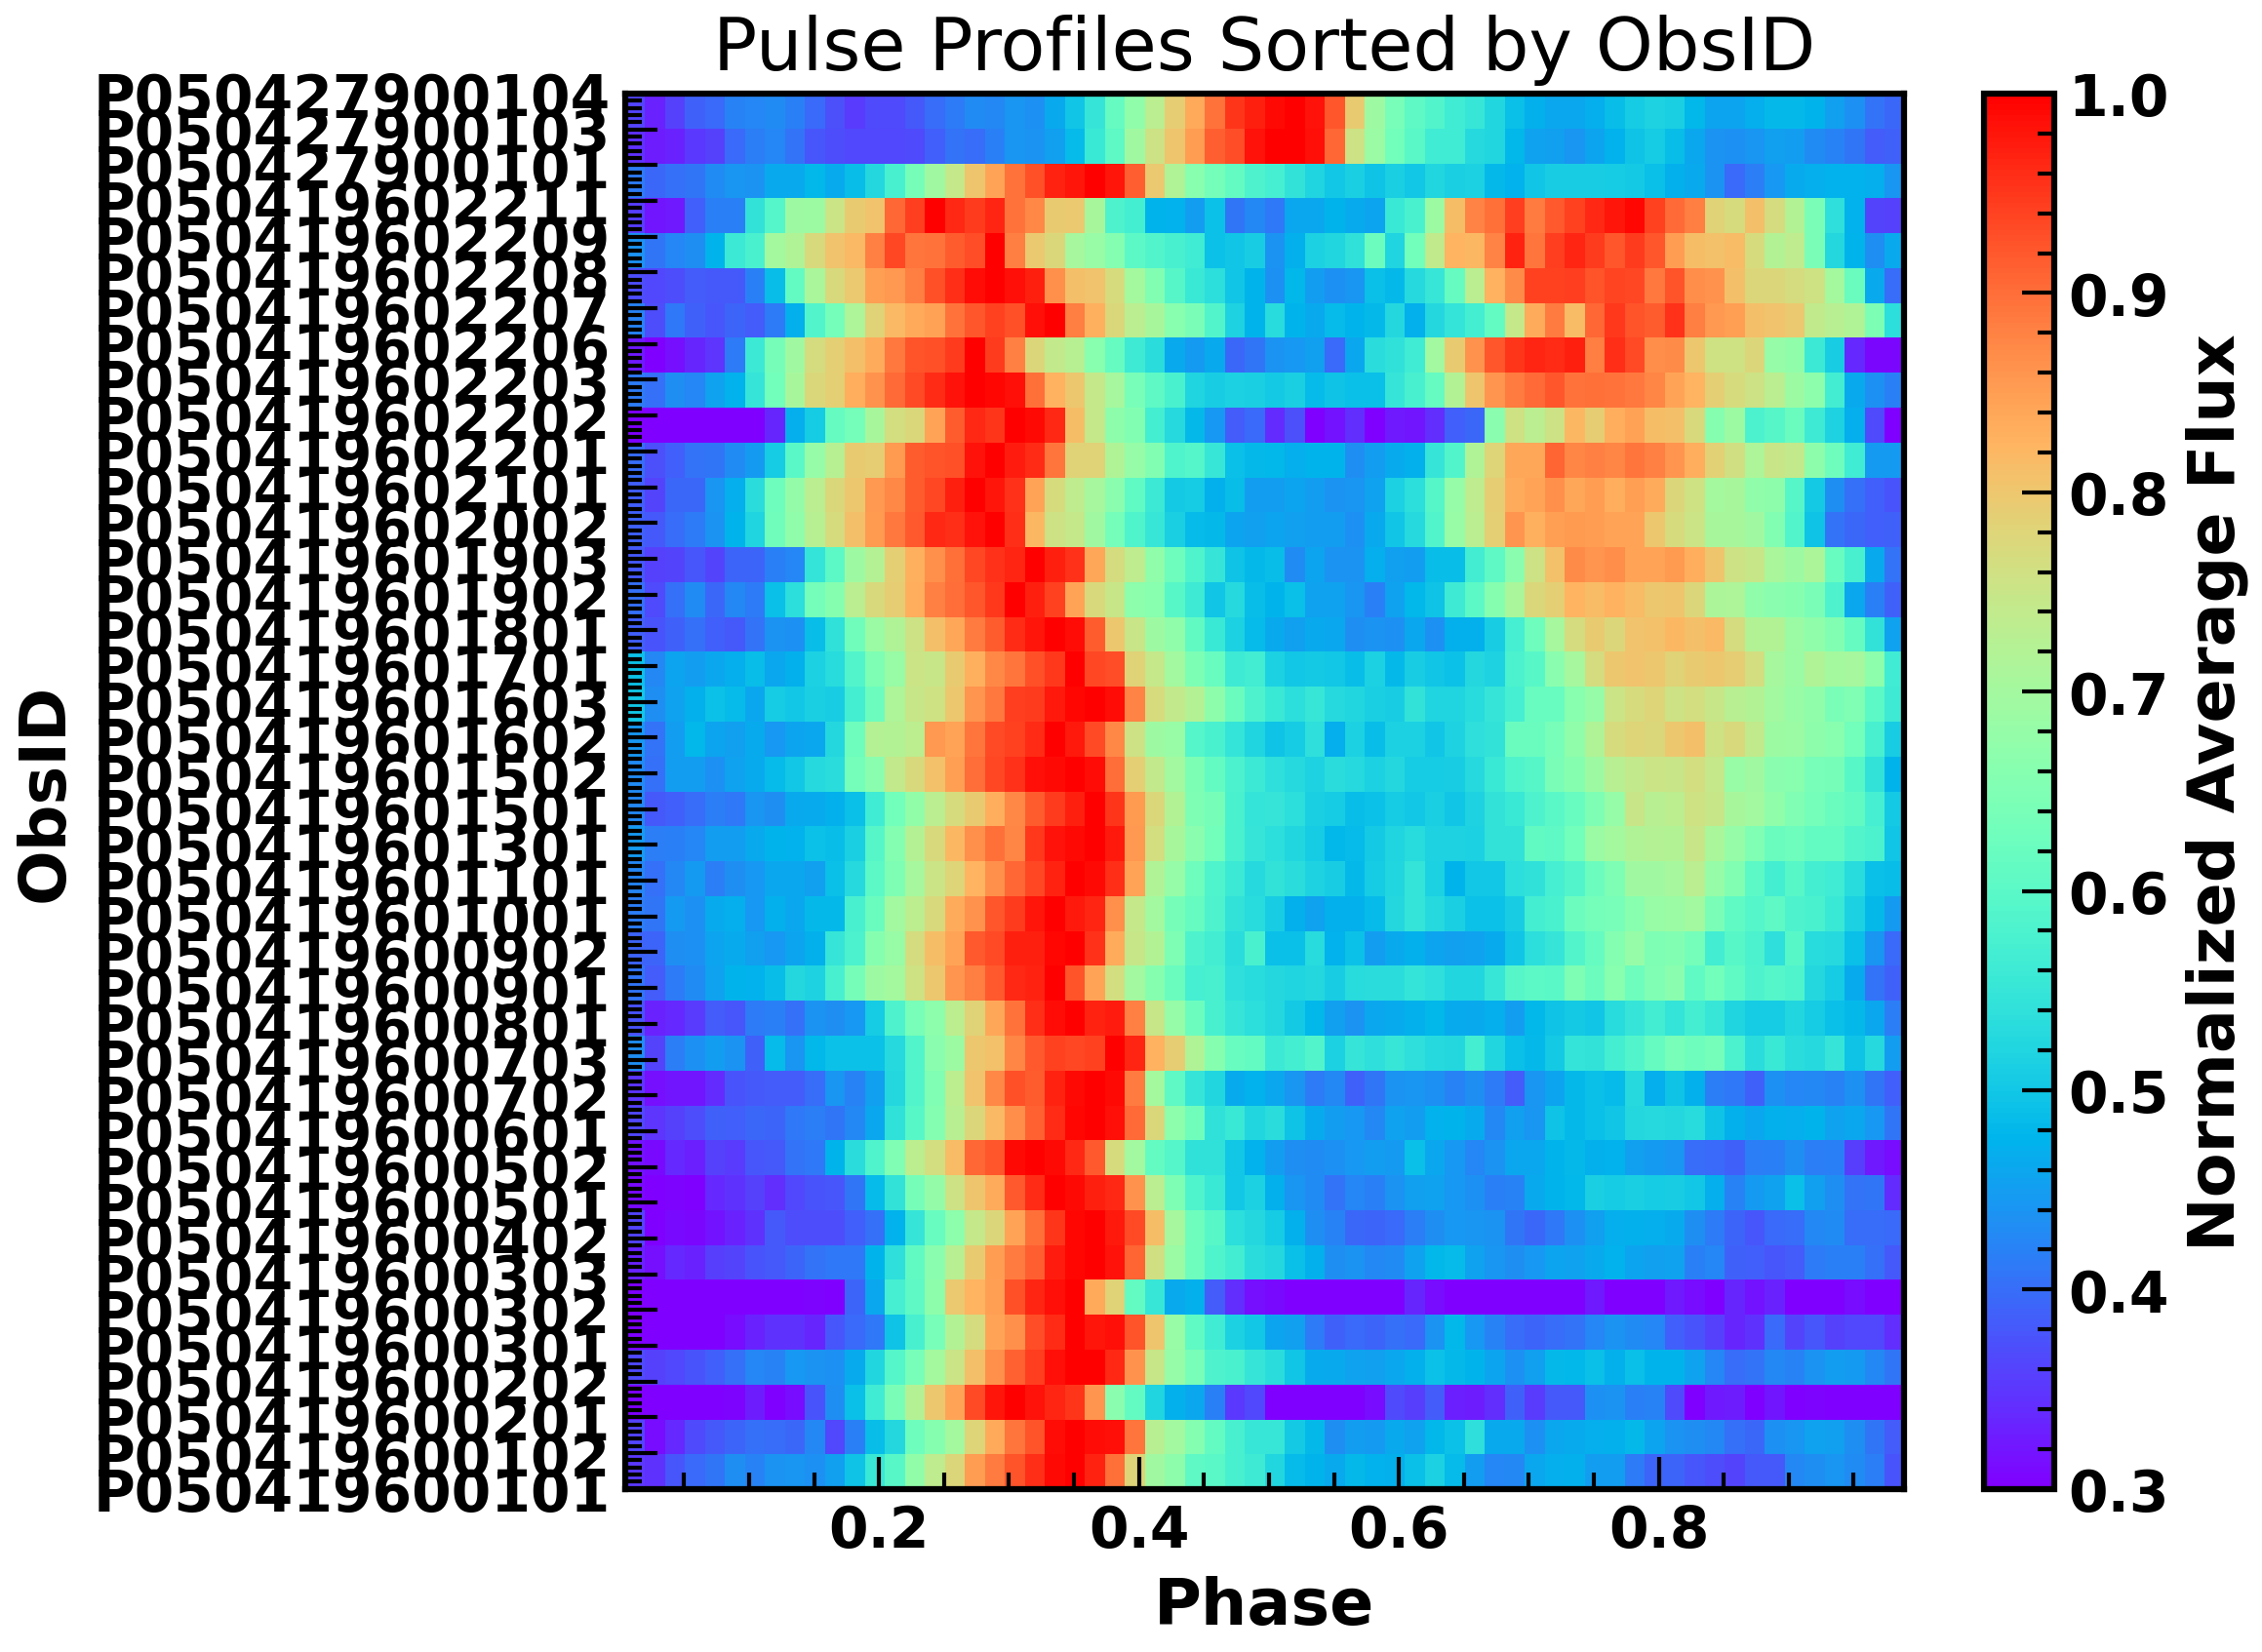

In [36]:
plot_pulse_profiles_by_obsid(le_matched_files,0,6e37)
plot_pulse_profiles_by_obsid(me_matched_files,0,6e37)
plot_pulse_profiles_by_obsid(he_matched_files,0,7e37)

## Make Combined LE+ME

In [37]:
def make_combined_LE_ME_colormap(base_path="./hxmt_efold_output", nphase=64, output_file="combined_LE_ME_colormap.png"):
    exposure_ids_all = sorted(os.listdir(base_path))
    combined_profiles = []
    exposure_ids_used = []  # store only the ones used

    for exp_id in exposure_ids_all:
        le_file = os.path.join(base_path, exp_id, "LE", f"{exp_id}_LE_pulse_profile_efold_output_same_epoch.fits")
        me_file = os.path.join(base_path, exp_id, "ME", f"{exp_id}_ME_pulse_profile_efold_output_same_epoch.fits")

        if not (os.path.exists(le_file) and os.path.exists(me_file)):
            print(f"[SKIP] Missing LE or ME file for {exp_id}")
            continue

        try:
            with fits.open(le_file) as le_hdul, fits.open(me_file) as me_hdul:
                le_profile = le_hdul[1].data['RATE1'].astype(float)
                me_profile = me_hdul[1].data['RATE1'].astype(float)

            if len(le_profile) != nphase or len(me_profile) != nphase:
                print(f"[SKIP] Profile size mismatch in {exp_id}")
                continue


            combined_profile = le_profile + me_profile
            combined_profile/=np.max(combined_profile)
            combined_profiles.append(combined_profile)
            exposure_ids_used.append(exp_id)

        except Exception as e:
            print(f"[ERROR] Failed for {exp_id}: {e}")
            continue

    if not combined_profiles:
        print("❌ No valid LE+ME profiles to plot.")
        return

    profile_matrix = np.array(combined_profiles)

    # Plot colormap with exposure IDs as Y labels
    plt.figure(figsize=(12, 6))
    im = plt.imshow(profile_matrix, aspect='auto', cmap='rainbow', origin='lower',
                    extent=[0, 1, 0, len(profile_matrix)])
    plt.colorbar(im, label='LE + ME (max-normalized)')
    plt.xlabel("Pulse Phase")
    plt.ylabel("Exposure ID")
    plt.title("Combined LE + ME Pulse Profiles (Shape-Preserving Normalization)")

    # Set exposure ID labels on y-axis
    yticks = np.arange(len(exposure_ids_used))
    plt.yticks(yticks, exposure_ids_used, fontsize=8)
    plt.tight_layout()
    plt.show()

In [38]:
def read_and_plot_fits_file(file_path):

    plt.figure(figsize=(10, 6))
    for files in file_path:
        print(files)
        # Open the FITS file
        with fits.open(files) as hdul:

            # Assuming you want to plot the first HDU (Header Data Unit)
            data = hdul[1].data

            # Plotting the data
            plt.plot(data['PHASE'], data['RATE1'], marker='o', linestyle='-', label=files.split('/')[-2])

    plt.xlabel('PHASE')
    plt.ylabel('RATE1')
    plt.title('Combined Period vs Date from FITS files')
    plt.legend()
    plt.grid()

/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/LE/P050419600101_LE_pulse_profile_efold_output_same_epoch.fits
/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/ME/P050419600101_ME_pulse_profile_efold_output_same_epoch.fits


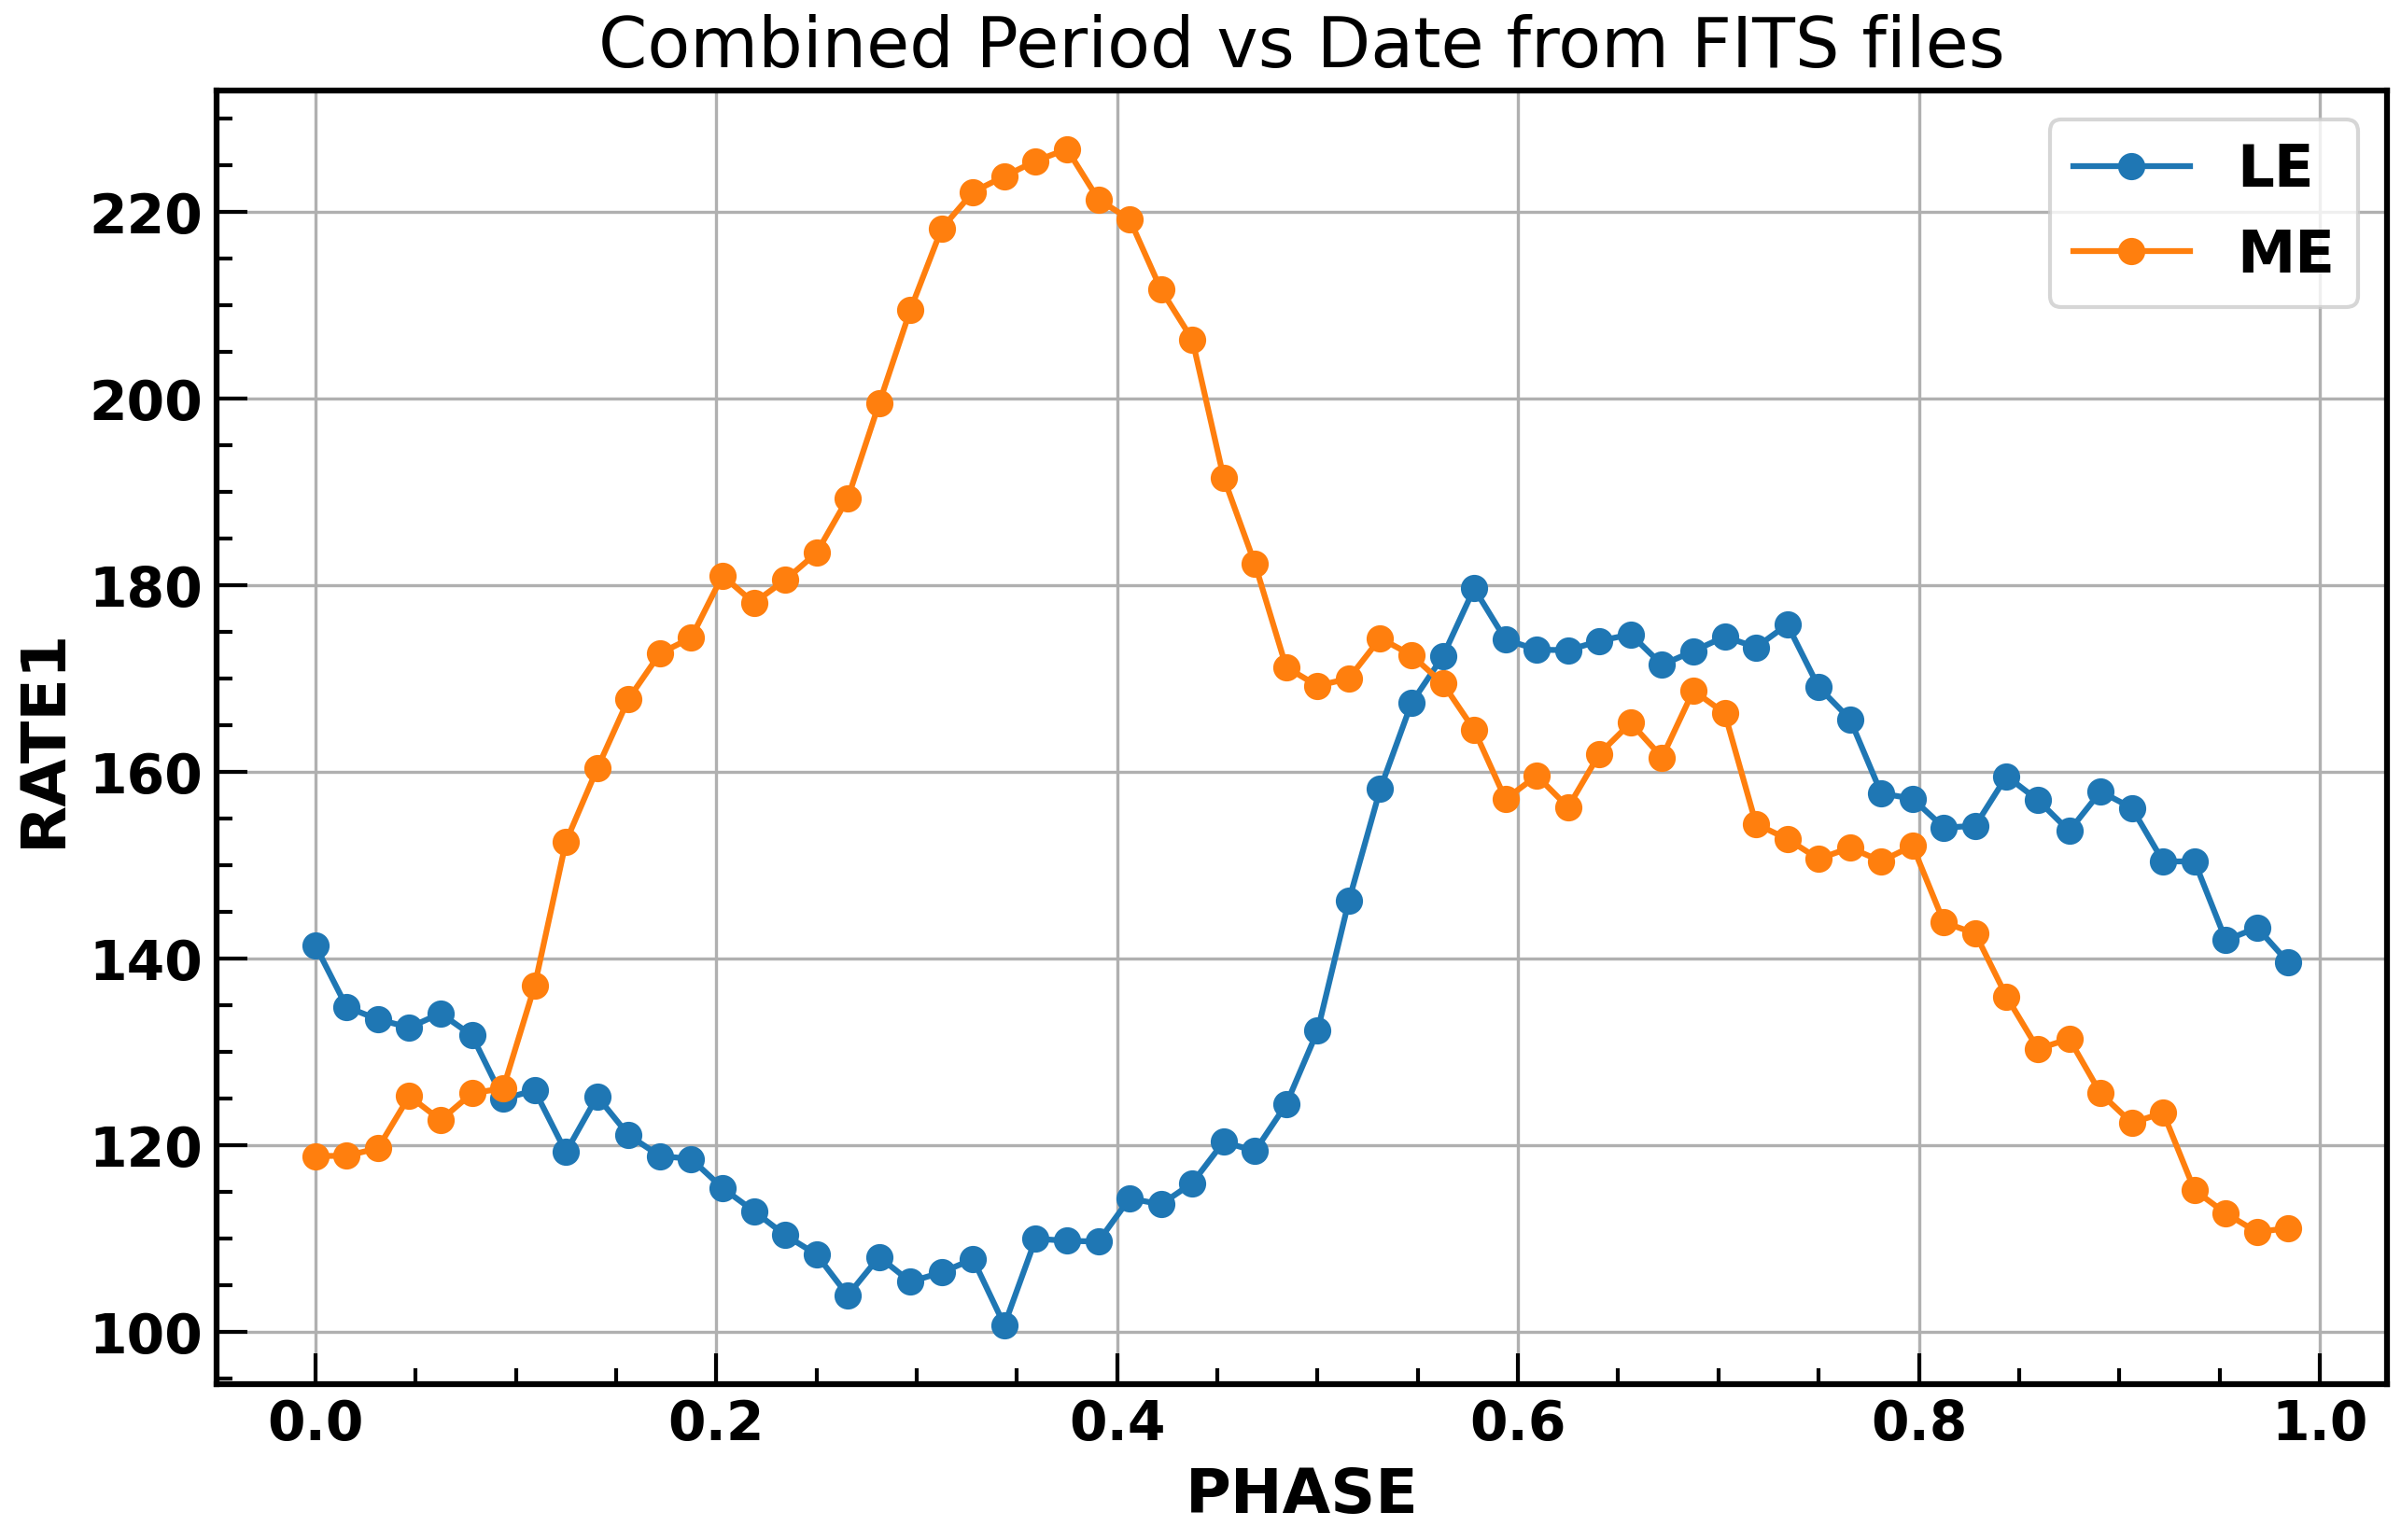

In [39]:
file_paths=[
'/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/LE/P050419600101_LE_pulse_profile_efold_output_same_epoch.fits',
'/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/ME/P050419600101_ME_pulse_profile_efold_output_same_epoch.fits',]

read_and_plot_fits_file(file_paths)

[SKIP] Missing LE or ME file for P050419600103
[SKIP] Missing LE or ME file for P050419600403
[SKIP] Missing LE or ME file for P050419600603
[SKIP] Missing LE or ME file for P050419600703
[SKIP] Missing LE or ME file for P050419601201
[SKIP] Missing LE or ME file for P050419601402
[SKIP] Missing LE or ME file for P050419601403
[SKIP] Missing LE or ME file for P050419601601
[SKIP] Missing LE or ME file for P050419601701
[SKIP] Missing LE or ME file for P050419601901
[SKIP] Missing LE or ME file for P050419602102
[SKIP] Missing LE or ME file for P050419602204


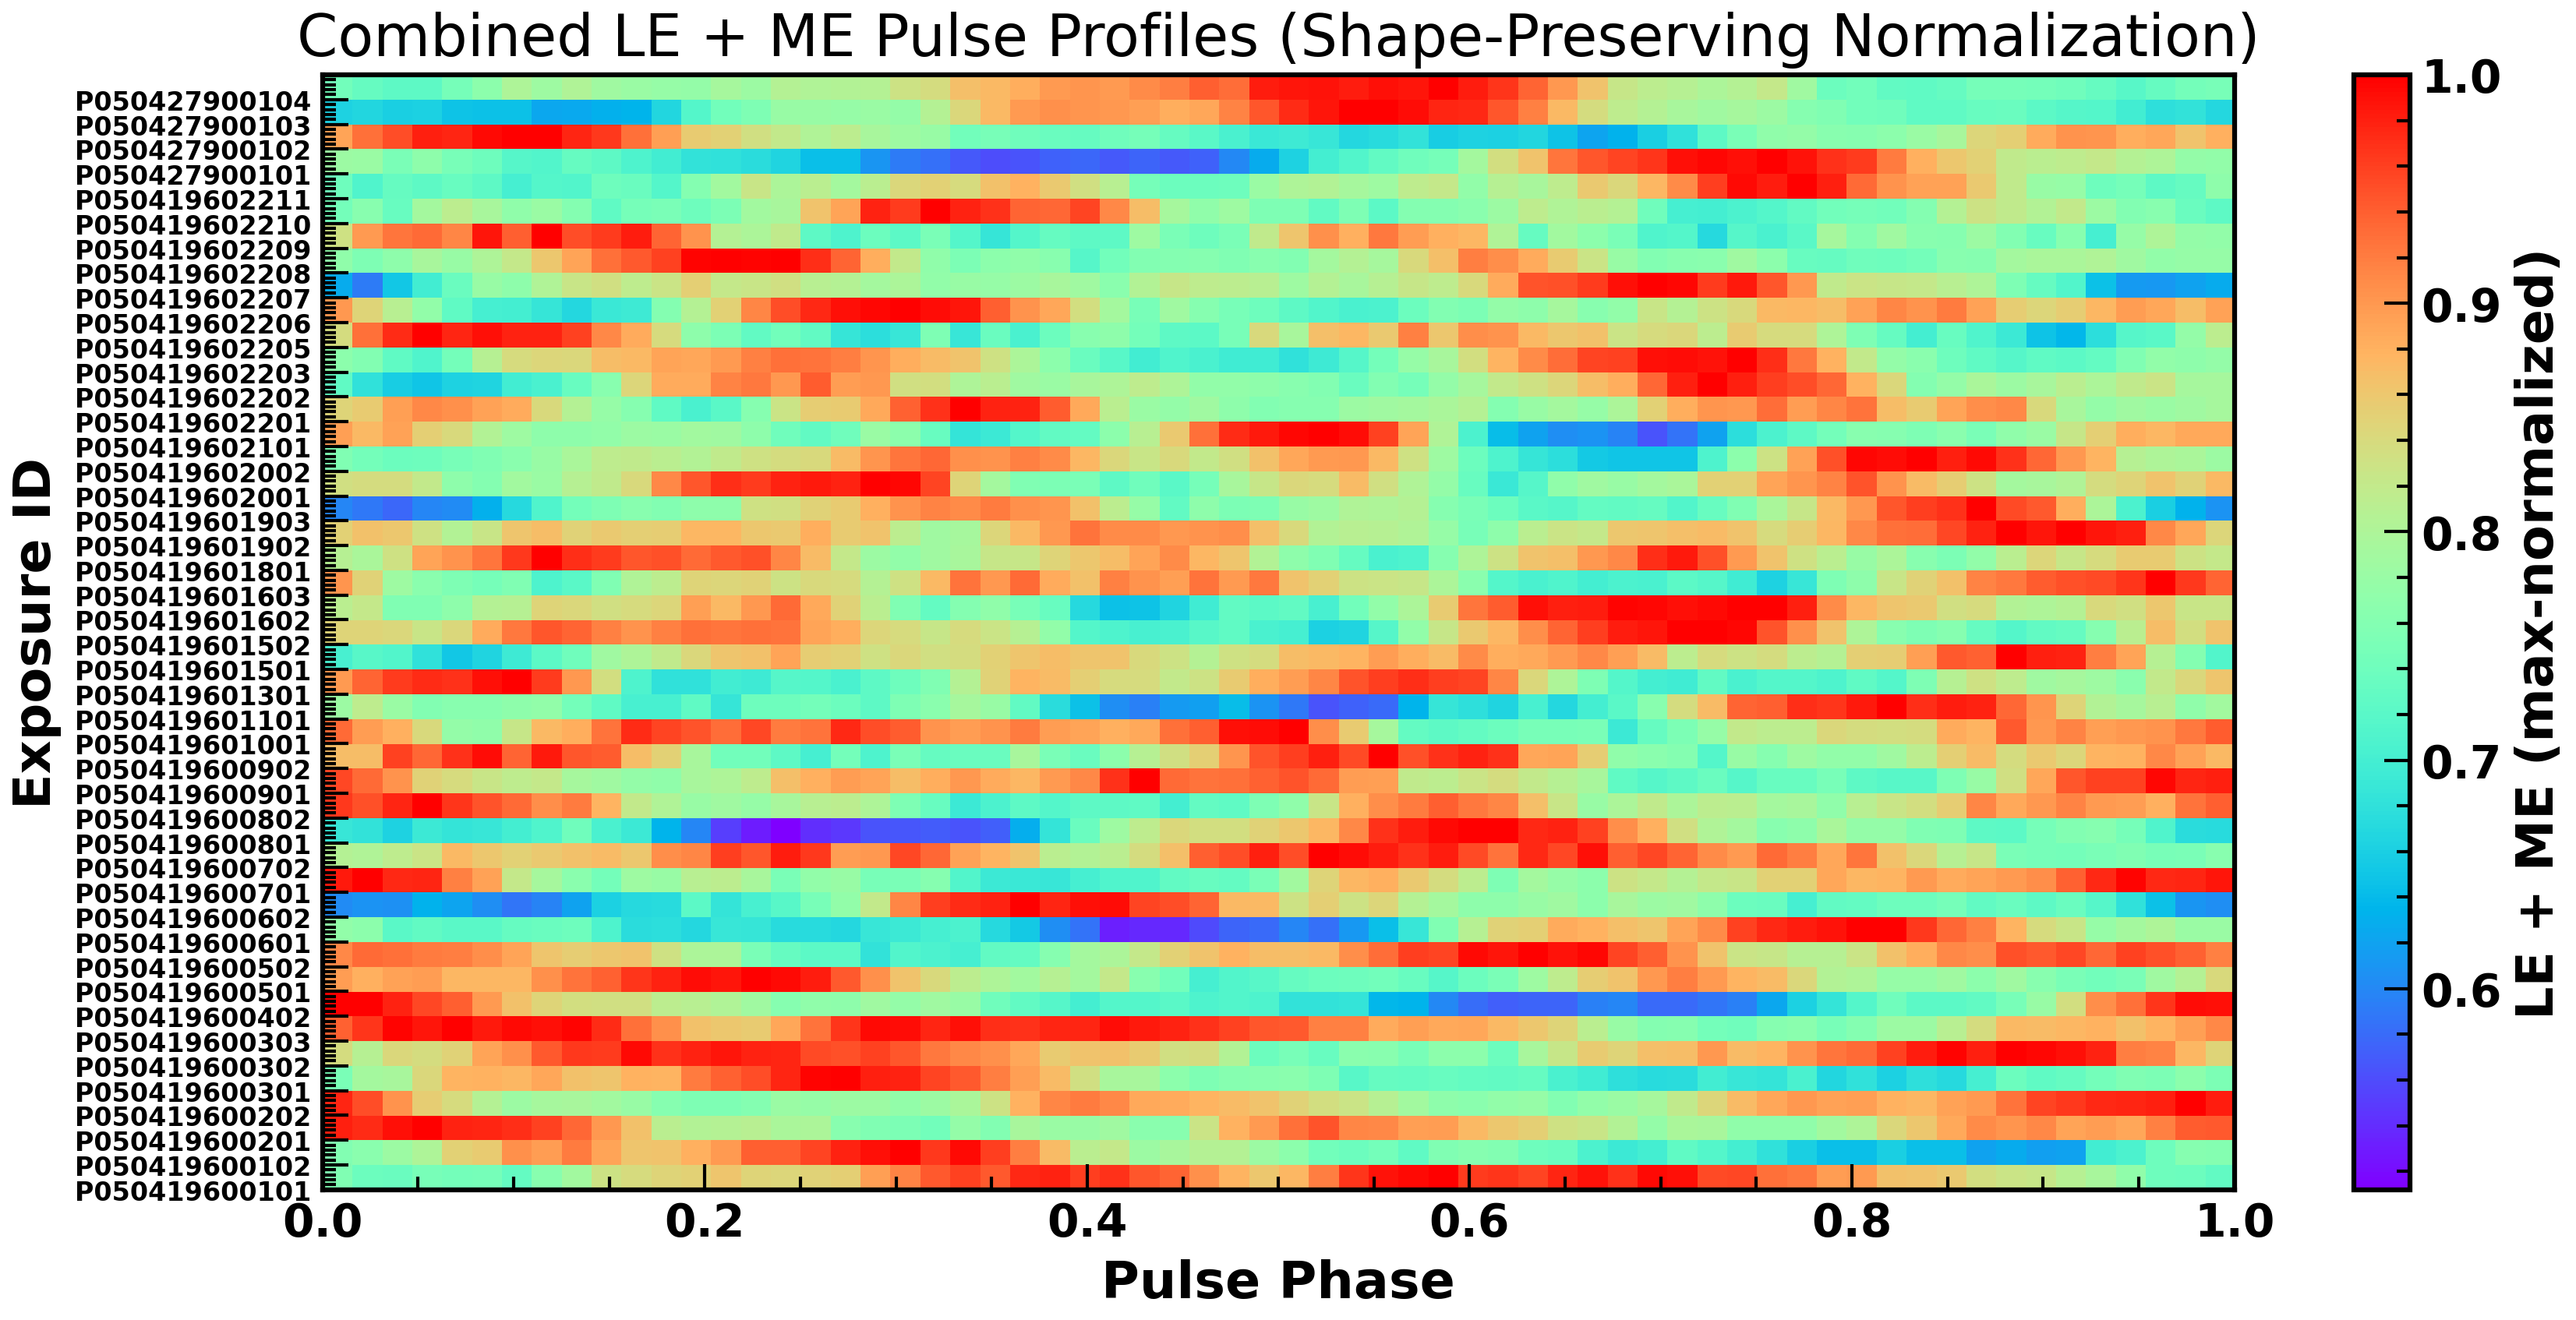

In [40]:
make_combined_LE_ME_colormap()